In [418]:
#copy right:Jie Huang Edited on 10/25/2023
#free to use
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import os
#plot original images
def PlotHist(Ipath):
    folder_path=Ipath
    files = os.listdir(folder_path)
    i=1
    for file in files:
        if os.path.isfile(os.path.join(folder_path, file)) and file[len(file)-3:]=="raw":
            print(file[len(file)-3:])
            print(os.path.join(folder_path, file))
            # Define image dimensions
            width = 256
            height = 256
            # Read the raw image data
            with open(os.path.join(folder_path, file), 'rb') as f:
                # Read the binary data into a NumPy array
                # 8-bit
                img_data = np.fromfile(f,dtype=np.uint8)
            #figure 1 hists
            plt.figure(1,figsize=(18, 5))
            plt.subplot(1,len(files),i)
            print(np.shape(img_data))
            plt.hist(img_data)
            plt.title(os.path.join(folder_path, file))
            #figure2 images
            plt.figure(2,figsize=(10, 4))
            plt.subplot(1,len(files),i)
            # Reshape the 1D array to a 2D image
            img = img_data.reshape((height, width))
            plt.imshow(img)
            i+=1     
    plt.tight_layout()
    plt.show()
            

#quantized files are no longer 8-bits
# plot quantized images
def PlotHistQuantized(Ipath):   
    folder_path=Ipath
    files = os.listdir(folder_path)
    i=1
    for file in files:
        if os.path.isfile(os.path.join(folder_path, file)) and file[len(file)-3:]=="raw":
            print(file[len(file)-3:])
            print(os.path.join(folder_path, file))
            # Define image dimensions
            width = 256
            height = 256
            # Read the raw image data
            with open(os.path.join(folder_path, file), 'rb') as f:
                # Read the binary data into a NumPy array
                # 8-bit
                img_data = np.fromfile(f)
            #figure 1 hists
            plt.figure(1,figsize=(25, 5))
            plt.subplot(1,len(files),i)
            print(np.shape(img_data))
            plt.hist(img_data)
            plt.title(os.path.join(folder_path, file))
            #figure2 images
            plt.figure(2,figsize=(24,4 ))
            plt.subplot(1,len(files),i)
            # Reshape the 1D array to a 2D image
            img = img_data.reshape((height, width))
            plt.imshow(img)
            i+=1     
    plt.tight_layout()
    plt.show()

def entropy(data):
    # result=[]
    # folder_path=path
    # files = os.listdir(folder_path)
    # for file in files:
    #     if os.path.isfile(os.path.join(folder_path, file)) and file[len(file)-3:]=="raw":
    #         # print(file[len(file)-3:])
    #         print(os.path.join(folder_path, file))
    #         # Define image dimensions
    #         width = 256
    #         height = 256
    #         # Read the raw image data
    #         with open(os.path.join(folder_path, file), 'rb') as f:
    #             # Read the binary data into a NumPy array
    #             # 8-bit
    #             img_data = np.fromfile(f)
    hist, _ = np.histogram(data)
    total_count = len(data)
    # print(total_count)
    # print(hist)
    probabilities = hist / total_count
    # print(probabilities)
    probabilities=probabilities[probabilities!=0]
    # print(probabilities)
    entropy=-np.sum(probabilities * np.log2(probabilities))
    return entropy

(b)Plot the histograms of the 6 original image files.

raw
training/people.raw
(65536,)
raw
training/boat.raw
(65536,)
raw
training/bike.raw
(65536,)


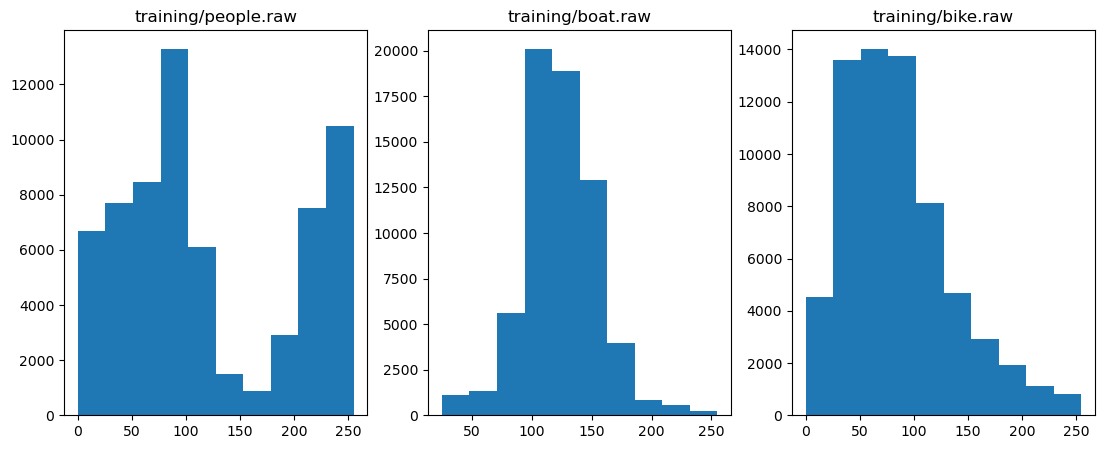

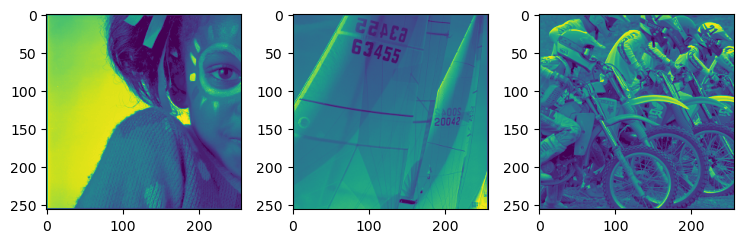

raw
testing/hat.raw
(65536,)
raw
testing/plane.raw
(65536,)
raw
testing/house.raw
(65536,)


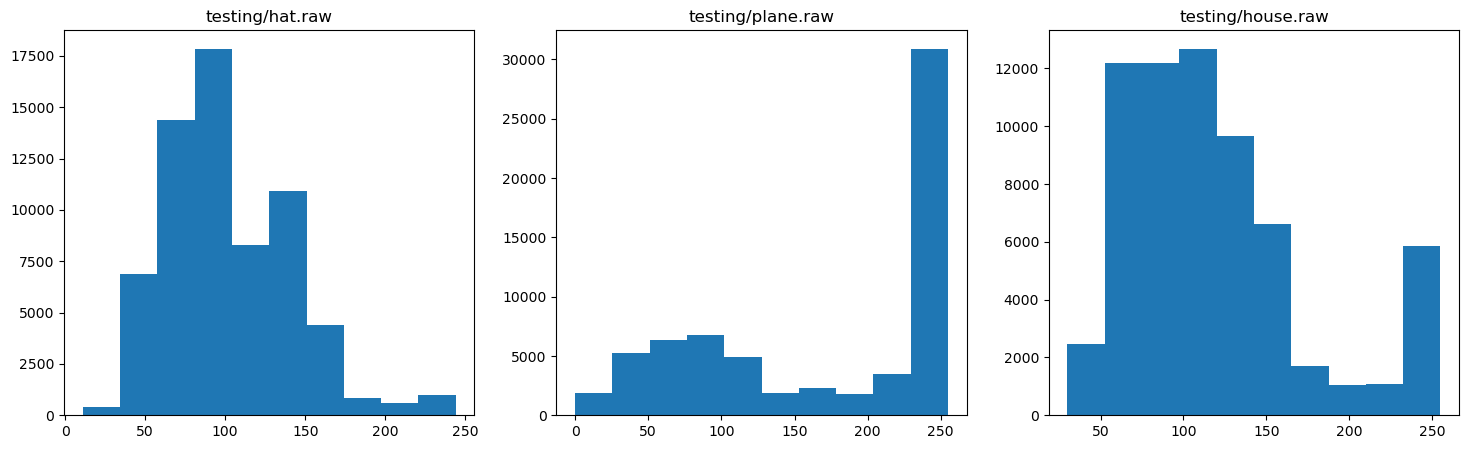

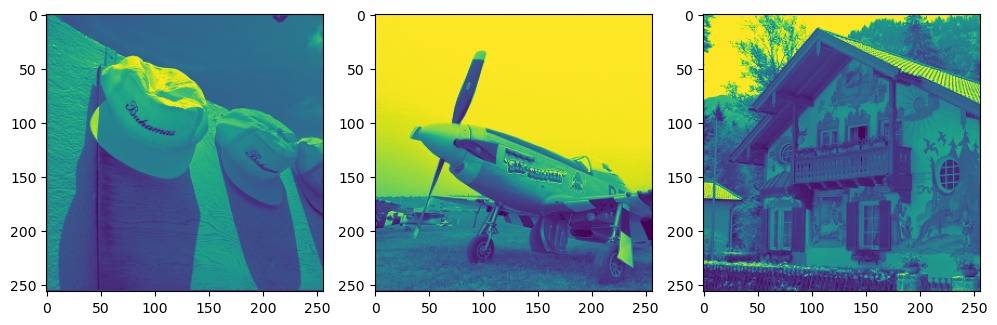

In [378]:
PlotHist('training')
PlotHist('testing')

Lloyd-Max scalar quantizer

In [419]:
#copy right:Jie Huang Edited on 10/25/2023
#free to use
#Lloyd-Max scalar quantizer
#path:path to folder
#bits: bits codeword
#tolerance: convergence
#iterMax: Maximum iterations
class LioydMax():
    def __init__(self,path,bits,tolerance,iterMax):
        self.path=path
        self.bits=bits
        self.codebook=None
        self.quantized_data=None
        self.tolerance=tolerance
        self.iterMax=iterMax
        self.data=None
    
    #initilize codebook
    def ini_centroid(self):
        self.codebook = np.linspace(np.min(self.data), np.max(self.data), 2**self.bits)
    
    #quantize data according to codebook
    def one_iteration(self):
        #compute the abs value of codeword and data
        #find the index of element with minimum abs value
        #get the corresponding value according to the index
        self.quantized_data = np.array([self.codebook[np.argmin(np.abs(self.codebook - d))] for d in self.data])
        #check the dimension of quantized_data
        if np.shape(self.quantized_data)!=np.shape(self.data):
            print("quantized_data dimension is wrong!")
            return -1
        return self.quantized_data 
    
    #return:[[image1_entropy,image1_PSNR],[image2_entropy,image2_PSNR],...]
    def PSNR(self,Ipath):
        result=[]
        folder_path = Ipath
        # List all files in the folder
        files = os.listdir(folder_path)
        for file in files:
            if os.path.isfile(os.path.join(folder_path, file)) and file[len(file)-3:]=="raw":
                with open(os.path.join(folder_path, file), 'rb') as f:
                        print(file)
                        # Read the binary data into a NumPy array
                        self.data = np.fromfile(f, dtype=np.uint8)
                        self.one_iteration()
                        mse=np.mean((self.data-self.quantized_data)**2)
                        result.append([entropy(self.quantized_data),10*np.log10((np.max(2**self.bits-1)**2)/mse)])
        return result
                        
    
    #train quantizer with current data
    def training(self):
        if self.codebook is None:
            self.ini_centroid()
        iter=0
        mse=999999
        while True:    
            iter+=1
            PrevMse=mse
            #assign data to codeword
            self.one_iteration()
            mse=np.mean((self.data-self.quantized_data)**2)
            # print(mse)
            # print(PrevMse-mse)
            # print(self.data)
            # print(self.quantized_data)
            # print(self.codebook)
            psnr=10*np.log10((np.max(2**self.bits-1)**2)/mse)
            print("PSNR: ",psnr)
            if PrevMse-mse<self.tolerance*mse or iter>self.iterMax:
                print("Iteration :",iter)
                break
            #update codebook
            for i in range(len(self.codebook)):
                    #print(np.shape(self.data[self.quantized_data == self.codebook[i]]))
                    if np.shape(self.data[self.quantized_data == self.codebook[i]])==(0,):
                        # print("shape is 0")
                        self.codebook[i]=0
                    else:
                        #get all data assigned to codeword i, set mean as new codeword
                        self.codebook[i] = np.mean(self.data[self.quantized_data == self.codebook[i]])
    
    #train quantizer with all files in folder
    def trainAllfilesInPath(self):
        folder_path = self.path
        # List all files in the folder
        files = os.listdir(folder_path)
        for file in files:
            if os.path.isfile(os.path.join(folder_path, file)) and file[len(file)-3:]=="raw":
                with open(os.path.join(folder_path, file), 'rb') as f:
                        print(file)
                        # Read the binary data into a NumPy array
                        self.data = np.fromfile(f, dtype=np.uint8)
                        self.training()
    
    #Ipath: path for input files
    #Opath: path for output files
    def QuantizeAllFilesInPath(self,Ipath,Opath):
        folder_path = Ipath
        # List all files in the folder
        files = os.listdir(folder_path)
        for file in files:
            if os.path.isfile(os.path.join(folder_path, file)) and file[len(file)-3:]=="raw":
                with open(os.path.join(folder_path, file), 'rb') as f:
                        print(file)
                        # Read the binary data into a NumPy array
                        self.data = np.fromfile(f,dtype=np.uint8)
                        print("shape of data:",np.shape(self.data))
                        
                        # np.save(os.path.join(Opath, file[:len(file)-4]), self.one_iteration())
                        # print("shape of quantized_data:",np.shape(self.one_iteration()))
                # Save binary data to a file
                with open(os.path.join(Opath, file[:len(file)-4])+".raw", 'wb') as Ofile:
                    print("shape of quantized_data:",np.shape(self.one_iteration()))
                    self.one_iteration().tofile(Ofile)
                        
        
        

(b)
(2)
Train quantizer

the PSNR at each iteration.the number of iterations the algorithm takes to converge.

In [420]:
Bits3=LioydMax("training",3,0.001,100)
Bits3.trainAllfilesInPath()

# the PSNR at each iteration.the number of iterations the algorithm takes to converge.
# people.raw
# PSNR:  -3.554673958411864
# PSNR:  -1.7536245478161971
# PSNR:  -1.5204508698426797
# PSNR:  -1.4858686930624831
# PSNR:  -1.4683739486137521
# PSNR:  -1.4683739486137521
# Iteration : 6
# boat.raw
# PSNR:  -5.056104702853746
# PSNR:  -2.9240680941577875
# PSNR:  -1.8508250948910678
# PSNR:  -1.21056425142352
# PSNR:  -0.7812816827615106
# PSNR:  -0.5959679948052228
# PSNR:  -0.5003318020320977
# PSNR:  -0.4357371764621398
# PSNR:  -0.2943397107940943
# PSNR:  -0.10126047491314363
# PSNR:  0.1143037131087433
# PSNR:  0.4131844215212726
# PSNR:  0.8346440560113413
# PSNR:  1.1984201879179652
# PSNR:  1.3693453353471212
# PSNR:  1.4645440751362513
# PSNR:  1.4826247458315966
# PSNR:  1.5012851131869613
# PSNR:  1.5280470586821007
# PSNR:  1.5280470586821007
# Iteration : 20
# bike.raw
# PSNR:  -4.827660640031819
# PSNR:  -3.682937745111869
# PSNR:  -3.2350607358141974
# PSNR:  -2.96361502019343
# PSNR:  -2.7972167710425646
# PSNR:  -2.641338384525035
# PSNR:  -2.552684137333009
# PSNR:  -2.483547507994415
# PSNR:  -2.419605146212549
# PSNR:  -2.3607558539096223
# PSNR:  -2.297577001520705
# PSNR:  -2.208028279662614
# PSNR:  -2.122514325047774
# PSNR:  -2.0454349442568653
# PSNR:  -1.9769204160938505
# PSNR:  -1.8994457874743917
# PSNR:  -1.8333408066245775
# PSNR:  -1.774416816161861
# PSNR:  -1.7075232123723627
# PSNR:  -1.6467740865354505
# PSNR:  -1.6005291478339234
# PSNR:  -1.5277167954794904
# PSNR:  -1.4772784797139686
# PSNR:  -1.4401635325945008
# PSNR:  -1.4105209337628635
# PSNR:  -1.3932888352700612
# PSNR:  -1.3746296134788236
# PSNR:  -1.3556253606886093
# PSNR:  -1.3489596655287608
# PSNR:  -1.3424462866490716
# PSNR:  -1.3424462866490716
# Iteration : 31

          

people.raw
PSNR:  -3.554673958411864
PSNR:  -1.7536245478161971
PSNR:  -1.5204508698426797
PSNR:  -1.4858686930624831
PSNR:  -1.4683739486137521
PSNR:  -1.4683739486137521
Iteration : 6
boat.raw
PSNR:  -5.056104702853746
PSNR:  -2.9240680941577875
PSNR:  -1.8508250948910678
PSNR:  -1.21056425142352
PSNR:  -0.7812816827615106
PSNR:  -0.5959679948052228
PSNR:  -0.5003318020320977
PSNR:  -0.4357371764621398
PSNR:  -0.2943397107940943
PSNR:  -0.10126047491314363
PSNR:  0.1143037131087433
PSNR:  0.4131844215212726
PSNR:  0.8346440560113413
PSNR:  1.1984201879179652
PSNR:  1.3693453353471212
PSNR:  1.4645440751362513
PSNR:  1.4826247458315966
PSNR:  1.5012851131869613
PSNR:  1.5280470586821007
PSNR:  1.5280470586821007
Iteration : 20
bike.raw
PSNR:  -4.827660640031819
PSNR:  -3.682937745111869
PSNR:  -3.2350607358141974
PSNR:  -2.96361502019343
PSNR:  -2.7972167710425646
PSNR:  -2.641338384525035
PSNR:  -2.552684137333009
PSNR:  -2.483547507994415
PSNR:  -2.419605146212549
PSNR:  -2.36075585

In [421]:
Bits1=LioydMax("training",1,0.001,100)
Bits1.trainAllfilesInPath()

#people.raw
# PSNR:  -36.31850230955478
# PSNR:  -30.054275025133972
# PSNR:  -30.026768081176453
# PSNR:  -30.026316713476824
# Iteration : 4
# boat.raw
# PSNR:  -34.29277139191
# PSNR:  -26.13673632826412
# PSNR:  -25.899714491181378
# PSNR:  -25.835604356580806
# PSNR:  -25.82042311397595
# PSNR:  -25.817492505782184
# Iteration : 6
# bike.raw
# PSNR:  -33.42992831093584
# PSNR:  -29.725506118026964
# PSNR:  -29.554266004498288
# PSNR:  -29.489998384476742
# PSNR:  -29.468476283980575
# PSNR:  -29.459150811262486
# PSNR:  -29.4553623449411
# Iteration : 7

people.raw
PSNR:  -36.31850230955478
PSNR:  -30.054275025133972
PSNR:  -30.026768081176453
PSNR:  -30.026316713476824
Iteration : 4
boat.raw
PSNR:  -34.29277139191
PSNR:  -26.13673632826412
PSNR:  -25.899714491181378
PSNR:  -25.835604356580806
PSNR:  -25.82042311397595
PSNR:  -25.817492505782184
Iteration : 6
bike.raw
PSNR:  -33.42992831093584
PSNR:  -29.725506118026964
PSNR:  -29.554266004498288
PSNR:  -29.489998384476742
PSNR:  -29.468476283980575
PSNR:  -29.459150811262486
PSNR:  -29.4553623449411
Iteration : 7
people.raw
boat.raw
bike.raw
hat.raw
plane.raw
house.raw


In [424]:
Bits5=LioydMax("training",5,0.0001,100)
Bits5.trainAllfilesInPath()    
# people.raw
# PSNR:  22.329420539749588
# PSNR:  22.641712341906363
# PSNR:  22.728279658036733
# PSNR:  22.752396792166397
# PSNR:  22.758620089610627
# PSNR:  22.762512600978702
# PSNR:  22.762512600978702
# Iteration : 7
# boat.raw
# PSNR:  22.078236786641583
# PSNR:  22.39169794255753
# PSNR:  22.47535359034725
# PSNR:  22.483136698578253
# PSNR:  22.487033227516633
# PSNR:  22.492840017646984
# PSNR:  22.492840017646984
# Iteration : 7
# bike.raw
# PSNR:  19.98664432743794
# PSNR:  21.378921583996558
# PSNR:  21.515060937964417
# PSNR:  21.55011196302055
# PSNR:  21.583733240337093
# PSNR:  21.591904224212822
# PSNR:  21.591904224212822
# Iteration : 7

people.raw
PSNR:  22.329420539749588
PSNR:  22.641712341906363
PSNR:  22.728279658036733
PSNR:  22.752396792166397
PSNR:  22.758620089610627
PSNR:  22.762512600978702
PSNR:  22.762512600978702
Iteration : 7
boat.raw
PSNR:  22.078236786641583
PSNR:  22.39169794255753
PSNR:  22.47535359034725
PSNR:  22.483136698578253
PSNR:  22.487033227516633
PSNR:  22.492840017646984
PSNR:  22.492840017646984
Iteration : 7
bike.raw
PSNR:  19.98664432743794
PSNR:  21.378921583996558
PSNR:  21.515060937964417
PSNR:  21.55011196302055
PSNR:  21.583733240337093
PSNR:  21.591904224212822
PSNR:  21.591904224212822
Iteration : 7
people.raw
boat.raw
bike.raw
hat.raw
plane.raw
house.raw


(3)

Quantize the 3 training images as well as the 3 testing images using designed quantizers.

Showing quantized images and histograms of 6 images after quantization

An idication for a good quantizer is preserving the distribution of pixel value.


In [376]:
Bits1.QuantizeAllFilesInPath("training","output1")
Bits1.QuantizeAllFilesInPath("testing","output1")
Bits3.QuantizeAllFilesInPath("training","output3")
Bits3.QuantizeAllFilesInPath("testing","output3")
Bits5.QuantizeAllFilesInPath("training","output5")
Bits5.QuantizeAllFilesInPath("testing","output5")

people.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
boat.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
bike.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
hat.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
plane.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
house.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
people.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
boat.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
bike.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
hat.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
plane.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
house.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
people.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
boat.raw
shape of data: (65536,)
shape of quantized_data: (65536,)
bike.raw
shape of data: (65536,)
shape of quantized_da

'output3': 3-bits quantizer

'output1': 1-bits quantizer

'output5': 5-bits quantizer

Quantized images

raw
output3/people.raw
(65536,)
raw
output3/hat.raw
(65536,)
raw
output3/boat.raw
(65536,)
raw
output3/plane.raw
(65536,)
raw
output3/bike.raw
(65536,)
raw
output3/house.raw
(65536,)


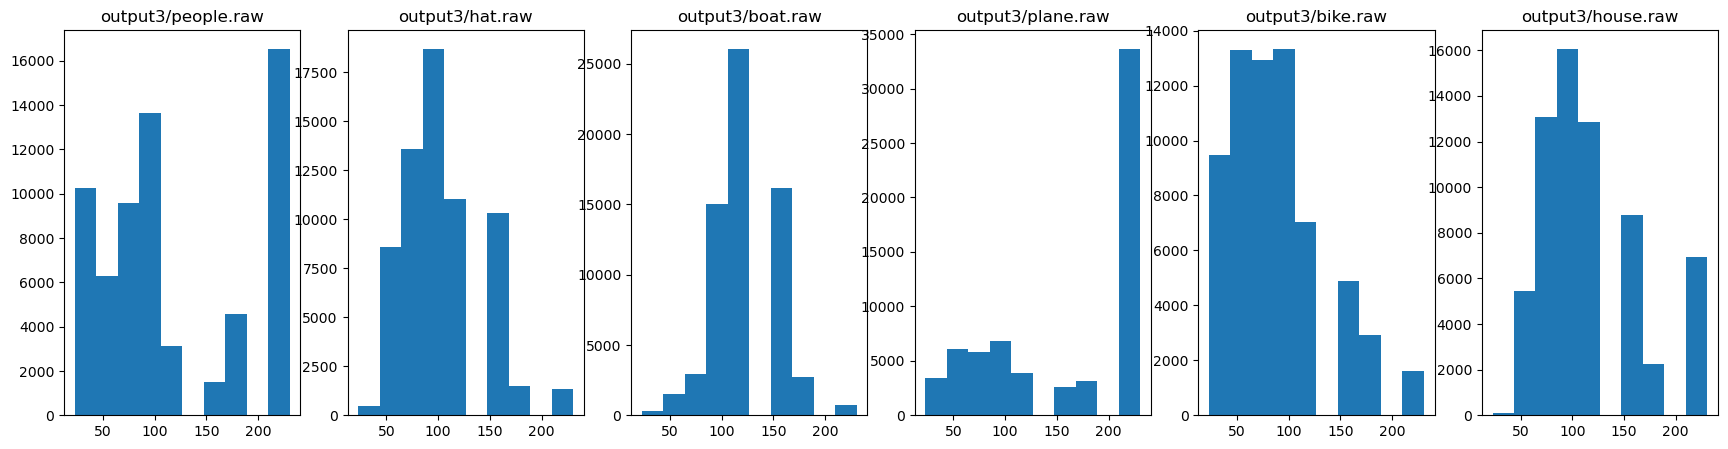

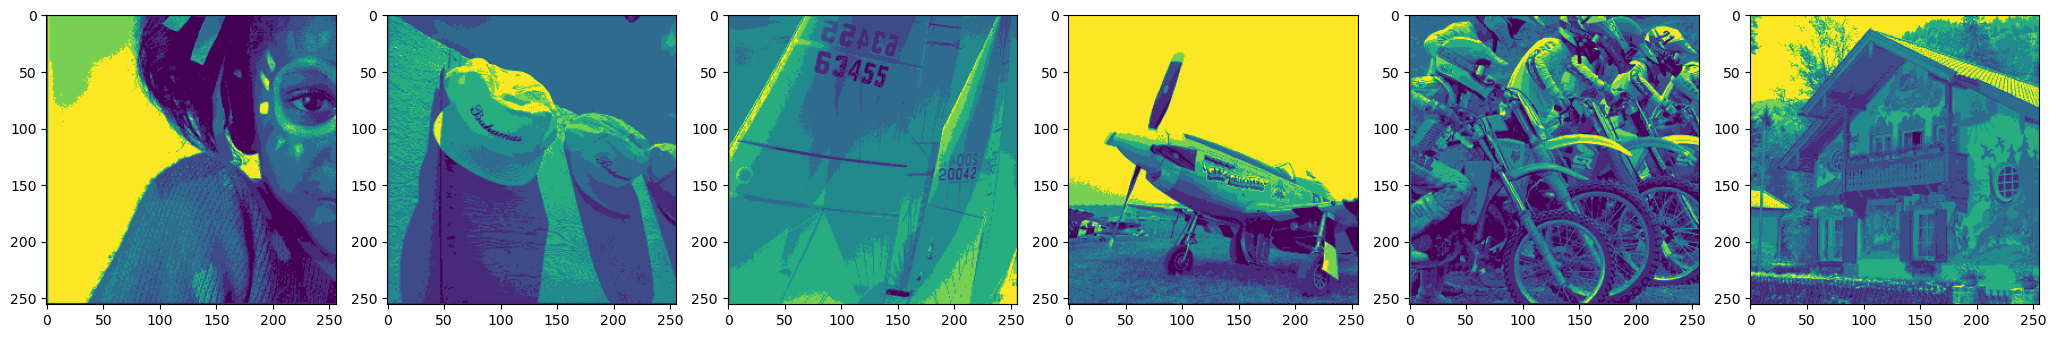

raw
output1/people.raw
(65536,)
raw
output1/hat.raw
(65536,)
raw
output1/boat.raw
(65536,)
raw
output1/plane.raw
(65536,)
raw
output1/bike.raw
(65536,)
raw
output1/house.raw
(65536,)


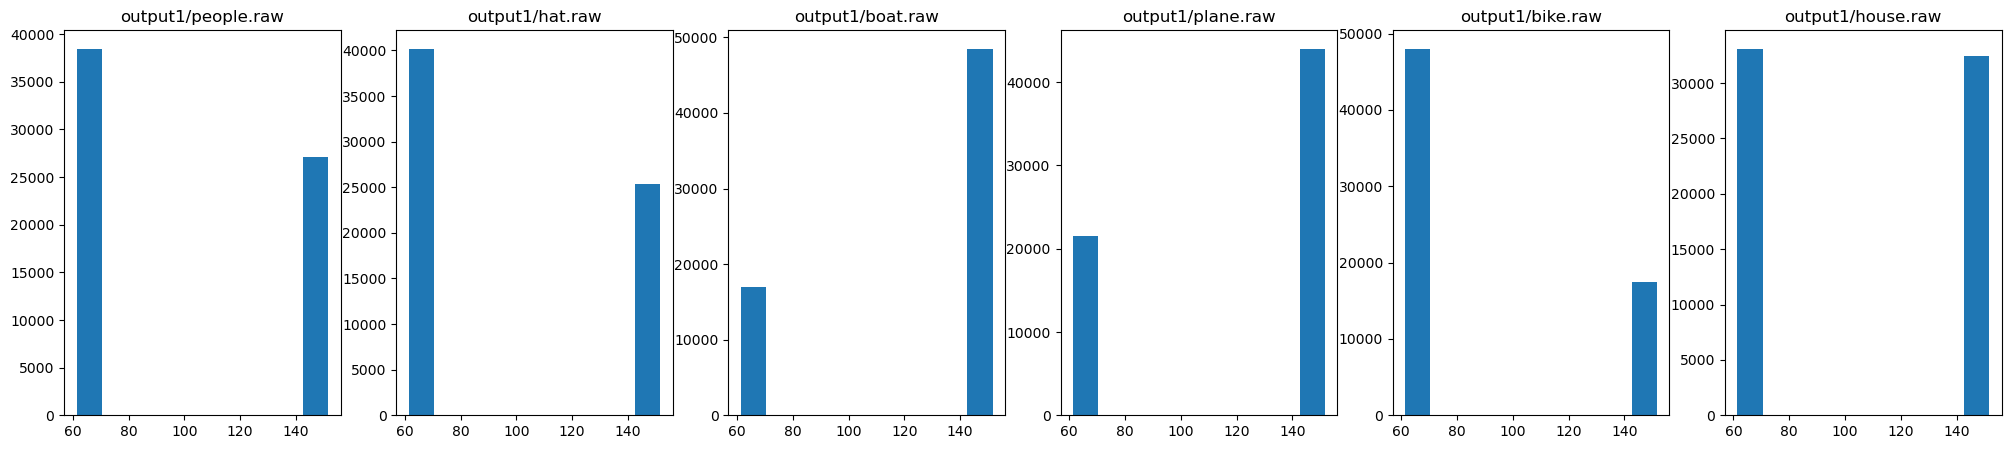

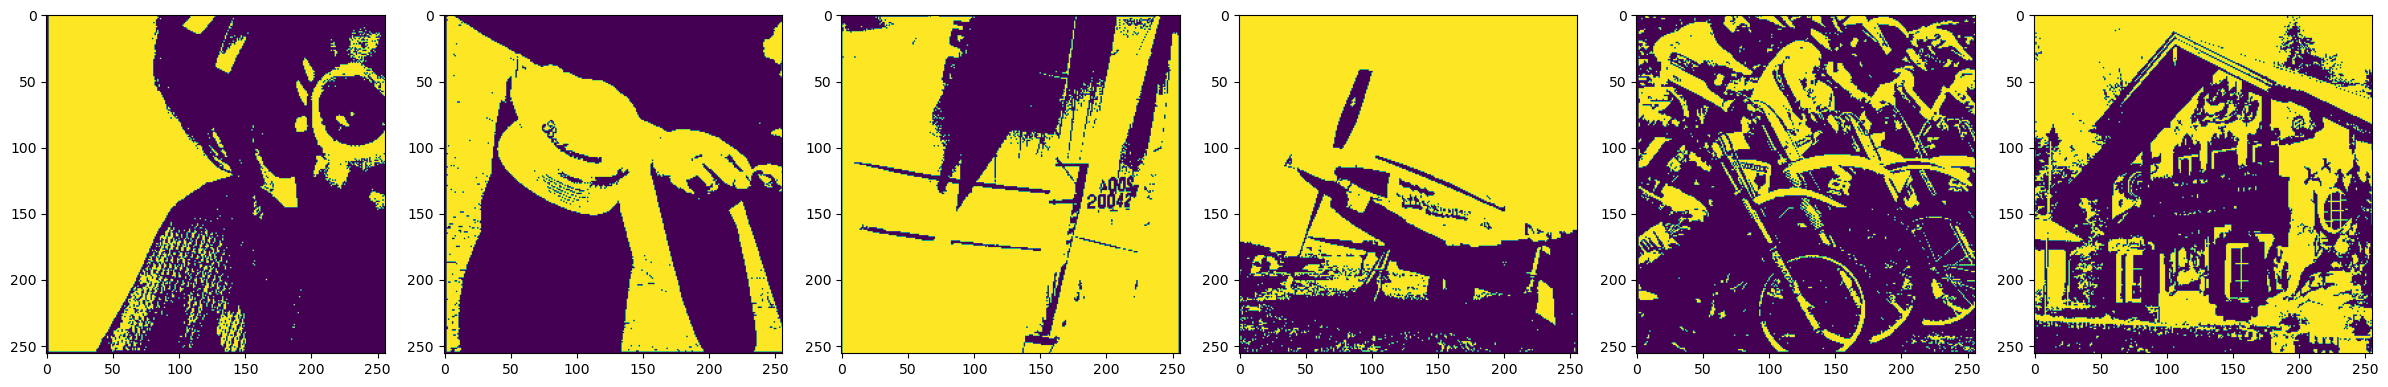

raw
output5/people.raw
(65536,)
raw
output5/hat.raw
(65536,)
raw
output5/boat.raw
(65536,)
raw
output5/plane.raw
(65536,)
raw
output5/bike.raw
(65536,)
raw
output5/house.raw
(65536,)


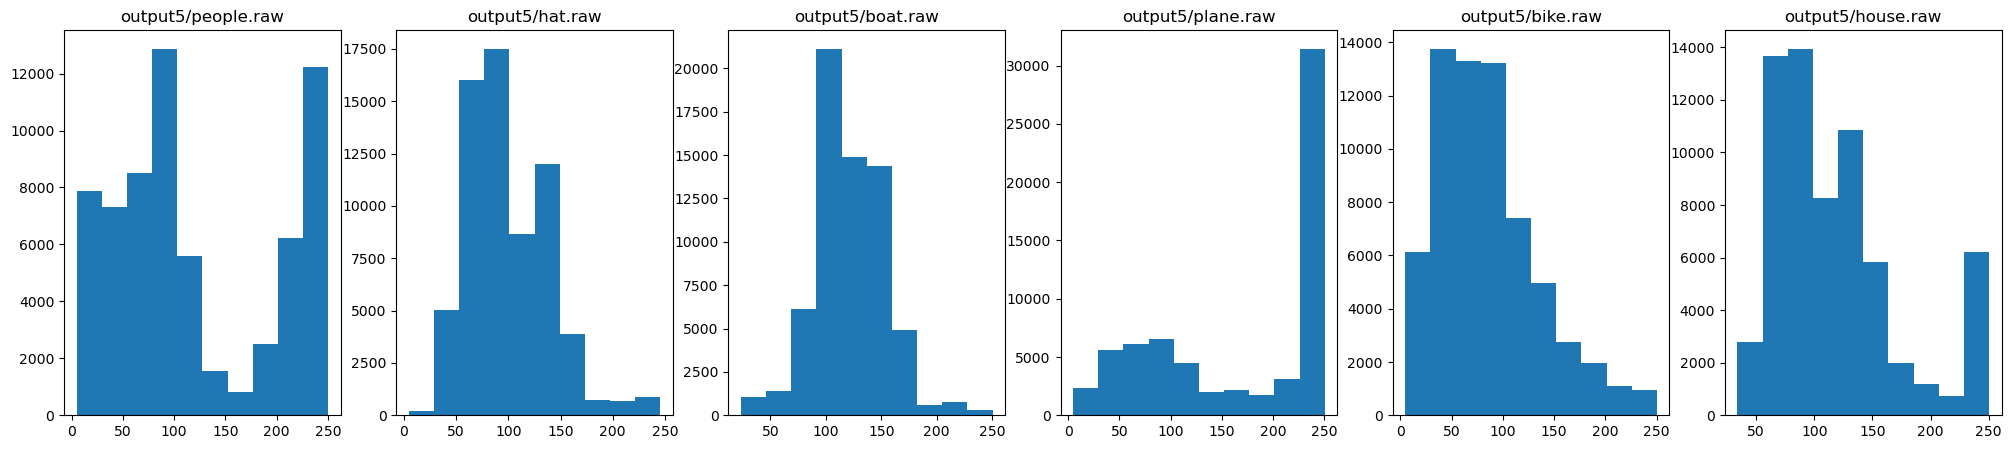

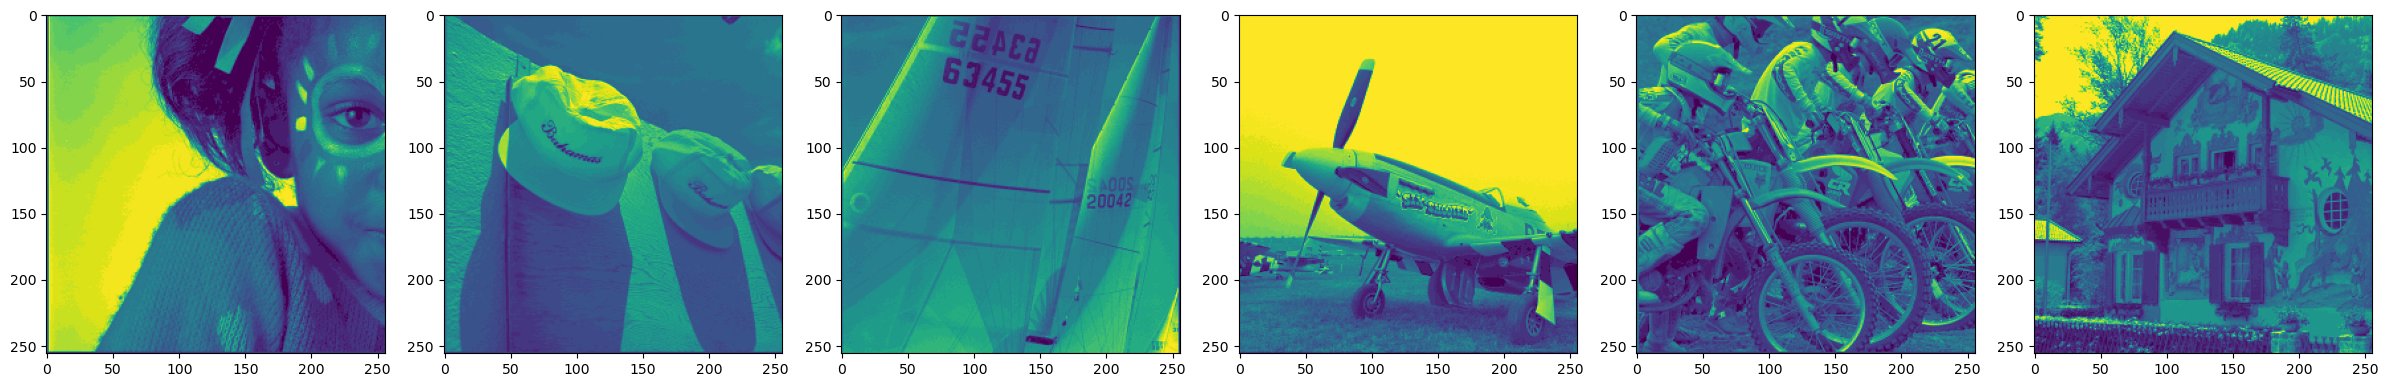

In [377]:
PlotHistQuantized('output3')
PlotHistQuantized('output1')
PlotHistQuantized('output5')

(4) Calculate the average code word length after quantization

In [430]:
Bits1RD=Bits1.PSNR("training")
Bits1RD=Bits1RD+(Bits1.PSNR("testing"))
Bits3RD=Bits3.PSNR("training")
Bits3RD=Bits3RD+(Bits3.PSNR("testing"))
Bits5RD=Bits5.PSNR("training")   
Bits5RD=Bits5RD+(Bits5.PSNR("testing"))
            

people.raw
boat.raw
bike.raw
hat.raw
plane.raw
house.raw
people.raw
boat.raw
bike.raw
hat.raw
plane.raw
house.raw
people.raw
boat.raw
bike.raw
hat.raw
plane.raw
house.raw


(5) Rate-Distortion analysis

In [451]:

#[[[image1_bits1_entropy,image1_bits1_PSNR],[image2_bits1_entropy,image2_bits1_PSNR],...],
# [[image1_bits3_entropy,image1_bits3_PSNR],[image2_bits3_entropy,image2_bits3_PSNR],...],
# [[image1_bits5,1_5],[2_5,2_5]...]]
RateDistortion=[]
RateDistortion.append(Bits1RD)
RateDistortion.append(Bits3RD)
RateDistortion.append(Bits5RD)
print(RateDistortion)
#transpose matrix to get rate-distortion pairs in a Rate (bits/pixel) – PSNR plane for each image.
RateDistortion=np.transpose(RateDistortion)
print(RateDistortion)

[[[0.9780383346182758, -34.02664794269599], [0.8265307752584559, -29.398162798478342], [0.8373687658911266, -29.4553623449411], [0.962588431177913, -28.268798927368863], [0.9131096137474284, -37.26841569430809], [0.9999172310946071, -31.964596609378162]], [[2.7237974535817546, -3.167028105538832], [2.142918830644071, -1.4421064015414449], [2.757109350183443, -1.3424462866490716], [2.514412959494766, -0.8800747328549448], [2.324256875968225, -7.351649808949374], [2.6323487065465896, -3.138683907733811]], [[3.0300542149702987, 21.233771749359207], [2.4785945417406507, 22.310589333943184], [2.8939361990263492, 21.591904224212822], [2.6136220572592057, 22.523810668178253], [2.563159705814038, 20.489000112945792], [2.911446788782392, 21.707442931612555]]]
[[[  0.97803833   2.72379745   3.03005421]
  [  0.82653078   2.14291883   2.47859454]
  [  0.83736877   2.75710935   2.8939362 ]
  [  0.96258843   2.51441296   2.61362206]
  [  0.91310961   2.32425688   2.56315971]
  [  0.99991723   2.6323

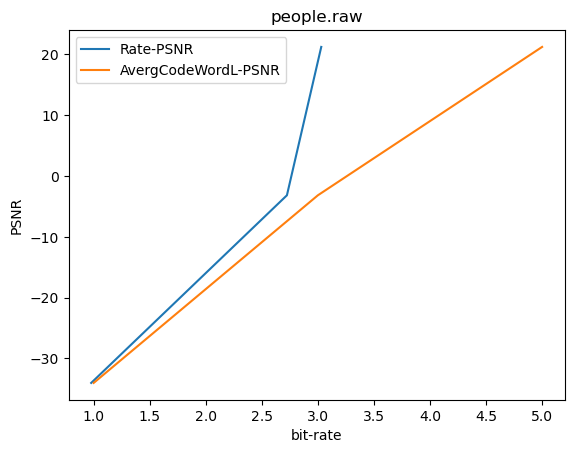

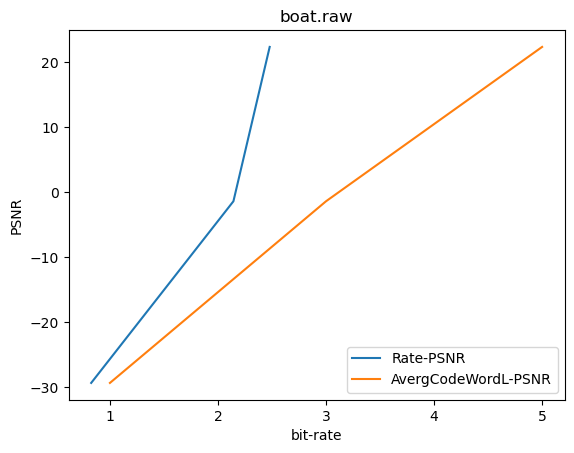

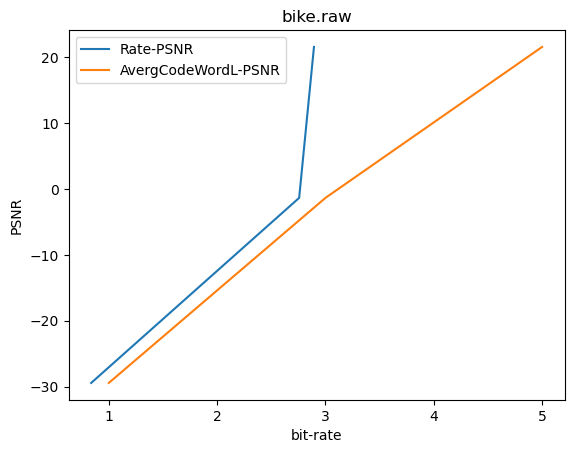

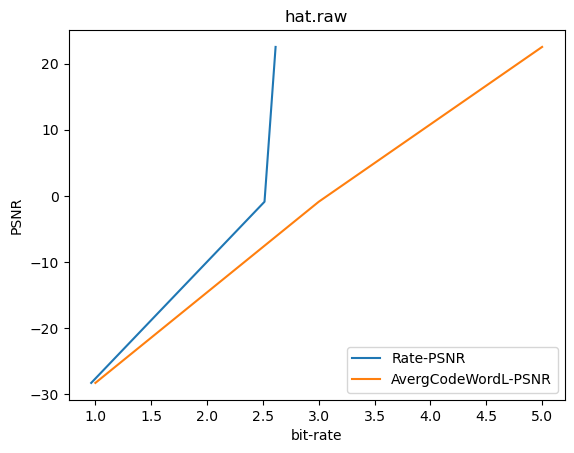

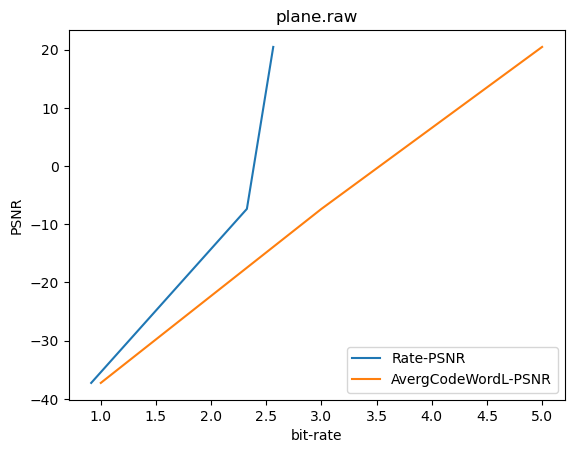

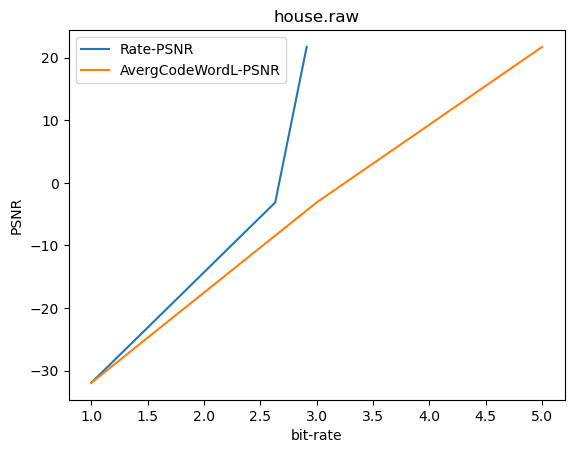

In [468]:
image_name=["people.raw",
"boat.raw",
"bike.raw",
"hat.raw",
"plane.raw",
"house.raw"]
for i in range(len(Bits3RD)):
    plt.plot(RateDistortion[0][i],RateDistortion[1][i],label="Rate-PSNR")
    plt.plot([1,3,5],RateDistortion[1][i],label="AvergCodeWordL-PSNR")
    plt.legend()
    plt.title(image_name[i])
    plt.xlabel("bit-rate")
    plt.ylabel("PSNR")
    plt.show()

3 bits quantizer needs more iterations to converge, while 1 bit and 5 bits one need less iterations. 1 bit quantizer's performance is not very well. 5 bits quantizer can achieve a good performance by using a small number of iterations. To conclusion, 5 bits quantizer work best.